# **Information on data acquisition and chosen interaction paradigms**
## **Data Acquisition**
* **No electromagnetic shielding or artifact control** was attempted for the recordings.
* Out of 22 channels used, the 2 ground leads are labeled $A_1$ and $A_2$. $X_3$ is used for data synchronization.
* Hardware filters of $0.53 - 70 Hz$ and $0.53 - 100 Hz$ are applied for EEG data recorded at sampling rates of $200 Hz$ and $1000 Hz$ respectively.
* A $50Hz$ notch filter is also applied to reduce electrical grid interference.
* **No terminal motion and E&M-related interference** occurred during data collection.
* **All electrode impedances were below specified levels** at the start and end of the recording session, and no other technical issues were present.
* **Post-hoc modifications** of data of any kinds were **not applied** to present researchers with the raw-est data possible.

## **NoMT interaction paradigm**
* **General description**: Similar to HaLT where 6 mental imageries of passive, left and right-hand, left and right-leg, and toungue movements are implemented but the participants were not asked to react to any visual signals appearing on the eGUI screen and this passively watched the computer screen for the duration of the recording session.
* Participants are given 2.5 minutes at the beginning to acclimatize to the recording session's conditions.
* Afterwards, each interaction segment is administered for 15 minutes.
* 3 BCI interation segments, each with a 2-minute break, form one recording session. During the rest period, participants were **allowed to talk or move** in their chair. The EEG data was continously recorded during rest periods as well. <br>
$\rightarrow$ **EEG data is continuously measured for a total length of 50 - 55 minutes**
* Each segment consisted of **a series of BCI interaction trials** in which a visual action signal was shown on eGUI screen to evoke some mental image.
* The signal **remains for $1s$** during which time the participant implemented the given mental imagery.
* Afterwards, the random duration **off-time of $1.5 - 2.5s$** followed, concluding the trial.

# **I. Environment setups**

In [1]:
import os
os.chdir('c:\\Users\\LENOVO\\Desktop\\Lab\\MotorImageryEEG')

In [1]:
# Necessary library
from typing import List
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras
import mne
%matplotlib inline

# Supporting functions and classes
from Utilities import *
from DataFile import DataFile

# For building, training, and evaluating model
from keras import layers
from tensorflow.math import reduce_mean, reduce_std
from tensorflow.data import Dataset, AUTOTUNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [2]:
# Constants
CLASS_LABELS = ["Subject F", "Subject H", "Subject I", "Subject J", "Subject K", "Subject L", "Subject M"]

# **II. Data extraction and formatting**

In [ ]:
files = [
    'data\\NoMTSubjectF1604220StNoMotor.mat',
    'data\\NoMTSubjectH1606280StNoMotor.mat',
    'data\\NoMTSubjectI1605120StNoMotor.mat',
    'data\\NoMTSubjectJ1610260StNoMotor.mat',
    'data\\NoMTSubjectK1610250StNoMotor.mat',
    'data\\NoMTSubjectL1610260StNoMotor.mat',
    'data\\NoMTSubjectM1611160StNoMotor.mat'
]

In [ ]:
datasets = []
for file in files:
  dataset = DataFile(file_path = file)
  dataset.generate()
  datasets.append(dataset)

Creating RawArray with float64 data, n_channels=22, n_times=664400
    Range : 0 ... 664399 =      0.000 ...  3321.995 secs
Ready.


<ipython-input-5-772564301>:285: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  self.format_data.set_annotations(events)


Creating RawArray with float64 data, n_channels=22, n_times=664600
    Range : 0 ... 664599 =      0.000 ...  3322.995 secs
Ready.


<ipython-input-5-772564301>:285: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  self.format_data.set_annotations(events)


Creating RawArray with float64 data, n_channels=22, n_times=662400
    Range : 0 ... 662399 =      0.000 ...  3311.995 secs
Ready.


<ipython-input-5-772564301>:285: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  self.format_data.set_annotations(events)


Creating RawArray with float64 data, n_channels=22, n_times=667600
    Range : 0 ... 667599 =      0.000 ...  3337.995 secs
Ready.


<ipython-input-5-772564301>:285: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  self.format_data.set_annotations(events)


Creating RawArray with float64 data, n_channels=22, n_times=734400
    Range : 0 ... 734399 =      0.000 ...  3671.995 secs
Ready.


<ipython-input-5-772564301>:285: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  self.format_data.set_annotations(events)


Creating RawArray with float64 data, n_channels=22, n_times=667000
    Range : 0 ... 666999 =      0.000 ...  3334.995 secs
Ready.


<ipython-input-5-772564301>:285: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  self.format_data.set_annotations(events)


Creating RawArray with float64 data, n_channels=22, n_times=678400
    Range : 0 ... 678399 =      0.000 ...  3391.995 secs
Ready.


<ipython-input-5-772564301>:285: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  self.format_data.set_annotations(events)


# **III.Preprocessing**

## **1. Filtering**
* **ECG artifacts** primarily exist in the $0 - 50Hz$ frequency range, with the strongest component typically below $1 - 2Hz$ due to slow waveforms of cardic activity.
* **EOG artifacts** are often in the $0 - 10Hz$ frequency range with the most dominant components in the $0 - 4Hz$ range. <br>
$\rightarrow$ **Unwise to apply any bandpass filter before running ICA for artifact correction. Interested signals in specific frequency band should be extracted later.**

## **2. Re-referencing**
The reference point for all recording was "System 0 V" as defined by the EEG-1200's technical manual at $0.55 \times (C_3 + C_4)V$

## **3. Artifact detection and correction**
* With no ECG or EOG channels, artifact-related methods provided by **MNE-Python** are rendered useless. Attempts to generate **synthetic EOG and ECG channels** have proven to be ineffective.
* We have to build a method from sratch if only EEG channels are used to correct EOG and ECG artifacts. For now, this process is skipped!

# **IV. Data samples**

## **1. Epoching data**

In [8]:
epochs_list = []
for i in range(len(datasets)):
  format_data = datasets[i].format_data
  events, event_id = mne.events_from_annotations(format_data)
  epochs = mne.Epochs(format_data, events, event_id,
                      tmin = -0.5, tmax = 2,
                      baseline = (None, 0), preload = True)
  subject = epochs.info["subject_info"]["his_id"]
  measurement_date = epochs.info["meas_date"]
  epochs.metadata = pd.DataFrame({"Subject" : [subject] * len(epochs),
                                  "Measurement Date" : [measurement_date] * len(epochs),
                                  "Class" : [i] * len(epochs)})
  epochs_list.append(epochs)

Used Annotations descriptions: [np.str_('blank'), np.str_('left hand'), np.str_('left leg'), np.str_('passive or neutral'), np.str_('right hand'), np.str_('right leg'), np.str_('tongue')]
Not setting metadata
1917 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1917 events and 501 original time points ...
9 bad epochs dropped
Adding metadata with 3 columns
Used Annotations descriptions: [np.str_('blank'), np.str_('left hand'), np.str_('left leg'), np.str_('passive or neutral'), np.str_('right hand'), np.str_('right leg'), np.str_('tongue')]
Not setting metadata
1905 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1905 events and 501 original time points ...
9 bad epochs dropped
Adding metadata with 3 columns
Used Annotations descriptions: [np.str

In [9]:
# Combine all epoch together
combined_epochs = mne.concatenate_epochs(epochs_list)

<ipython-input-9-917416234>:2: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  combined_epochs = mne.concatenate_epochs(epochs_list)


Adding metadata with 3 columns
13356 matching events found
Applying baseline correction (mode: mean)


In [10]:
combined_epochs.metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13356 entries, 1 to 13413
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   Subject           13356 non-null  object             
 1   Measurement Date  13356 non-null  datetime64[ns, UTC]
 2   Class             13356 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(1), object(1)
memory usage: 417.4+ KB


In [12]:
combined_epochs = shuffle_epochs(combined_epochs)

Adding metadata with 3 columns
13356 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


<ipython-input-11-2210019706>:13: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  shuffled_epochs = mne.EpochsArray(shuffled_data, epochs.info,


In [13]:
# Our data should be in shape (n_samples, n_signals, n_channels)
data = combined_epochs.get_data()
data = data.reshape((data.shape[0], data.shape[2], data.shape[1]))
data.shape

(13356, 501, 21)

## **2. Z-normalization**
Each timeseries sample should have a mean equal to 0 and a standard deviation euqal to one.

In [15]:
data = z_normalize(data, axis = [1])

## **3. Train and test split**

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
labels = np.array(combined_epochs.metadata["Class"])
labels

array([0, 1, 4, ..., 2, 3, 5])

In [18]:
X_train_val, X_test, y_train_val, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, stratify = y_train_val, random_state = 1)

In [19]:
X_train.shape, X_val.shape, X_test.shape

((8547, 501, 21), (2137, 501, 21), (2672, 501, 21))

In [20]:
# Train dataset
train_dataset = Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size = 1000).batch(32).prefetch(AUTOTUNE)

# Validation dataset
val_dataset = Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(128).prefetch(AUTOTUNE)

# Test dataset
test_dataset = Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(256).prefetch(AUTOTUNE)

# **V. Model training**

## **1. Build the model**

In [ ]:
def transformer_encoder(inputs : keras.Inputs, head_size : int, num_heads : int, ff_dim : int, dropout=0):
    """ 
    Build encoder blocks. 
    Each block has two sub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, position-wise fully connected feed-forward network. Residual connection is employed around each sub-layer, followed by layer normalization.
    
    Parameters:
    ----------
    inputs : keras.Inputs
        The model's input
    head_size : int
        Size of each attention head for query and key
    num_heads : int
        Number of attention heads
    ff_dim : int
        Number of filters in the convolution
    dropout : int
        Dropout rate (default is 0)

    Returns:
    ----------
    tf.tensor
        The model's output
        """
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu",
                      kernel_regularizer=keras.regularizers.l2(1e-4))(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1,
                      kernel_regularizer=keras.regularizers.l2(1e-4))(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [ ]:
def build_model(
    input_shape : tuple,
    head_size : int,
    num_heads : int,
    ff_dim : int,
    num_transformer_blocks : int,
    mlp_units : List[int],
    dropout=0,
    mlp_dropout=0,
):
    """
    Build Transformer model for time series classification.
    The model consists of identical encoder blocks stacked upon each other and the final Multi-Layer Perceptron classification head.

    Parameters:
    ----------
    input_shape : tuple
        Shape of the input of (batch size, sequence length, features)
    head_size : int
        Size of each attention head for query and key
    num_heads : int
        Number of attention heads
    ff_dim : int
        Number of filters in the convolution in the feed-forward part of an encoder block
    num_transformer_blocks : int
        The number of encoder blocks
    mlp_units : List[int]
        Units for Dense layers in the final Multi-Layer Perceptron classification head
    dropout : int
        Encoder's dropout rate (default is 0)
    mlp_dropout : int
        Multi-Layer Perceptron's dropout rate (default is 0)
    
    Returns:
    ----------
    keras.Model
        The built Transformer model
    """
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu", kernel_regularizer=keras.regularizers.l2(1e-4))(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(7, activation="softmax")(x)
    return keras.Model(inputs, outputs)

## **2. Train the model**

In [ ]:
input_shape = X_train.shape[1:]

model = build_model(
    input_shape,
    head_size=64,
    num_heads=3,
    ff_dim=64,
    num_transformer_blocks=2,
    mlp_units=[64, 32],
    mlp_dropout=0.4,
    dropout=0.3,
)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(),
    metrics=["sparse_categorical_accuracy"],
)

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
             keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.2),
             keras.callbacks.ModelCheckpoint("classifiers\\models\\Transformer.model.keras",
                                             monitor="val_sparse_categorical_accuracy",
                                             mode="max", save_best_only=True)]

history = model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs=100,
    callbacks=callbacks,
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 501, 21)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 501, 21)   │     16,725 │ input_layer[0][0… │
│ (MultiHeadAttentio… │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 501, 21)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 501, 21)   │         42 │ dropout_1[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 501, 21)   │          0 │ layer_normalizat… │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 501, 64)   │      1,408 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 501, 64)   │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 501, 21)   │      1,365 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 501, 21)   │         42 │ conv1d_1[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 501, 21)   │          0 │ layer_normalizat… │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 501, 21)   │     16,725 │ add_1[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 501, 21)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 501, 21)   │         42 │ dropout_4[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 501, 21)   │          0 │ layer_normalizat… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 501, 64)   │      1,408 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 501, 64)   │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 501, 21)   │      1,365 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 501, 21)   │         42 │ conv1d_3[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 501, 21)   │          0 │ layer_normalizat… │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 42,883 (167.51 KB)

 Trainable params: 42,883 (167.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 39s 84ms/step - loss: 1.9538 - sparse_categorical_accuracy: 0.1959 - val_loss: 1.5801 - val_sparse_categorical_accuracy: 0.3739 - learning_rate: 0.0010
Epoch 2/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 1.6457 - sparse_categorical_accuracy: 0.3635 - val_loss: 1.4219 - val_sparse_categorical_accuracy: 0.4675 - learning_rate: 0.0010
Epoch 3/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 1.5082 - sparse_categorical_accuracy: 0.4301 - val_loss: 1.3758 - val_sparse_categorical_accuracy: 0.4956 - learning_rate: 0.0010
Epoch 4/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 1.4899 - sparse_categorical_accuracy: 0.4447 - val_loss: 1.2964 - val_sparse_categorical_accuracy: 0.5068 - learning_rate: 0.0010
Epoch 5/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 1.3644 - sparse_categorical_accuracy: 0.5012 - val_loss: 1.2636 - val_sparse_categorical_accuracy: 0.5494 - learning_rate: 0.0010
Epoch 6/100
268/268 ━━━━━━━━━━━━━━━

[0.6535248756408691, 0.8154940009117126]

## **3. Evaluate the model**

In [27]:
# Model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 501, 21)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 501, 21)   │     16,725 │ input_layer[0][0… │
│ (MultiHeadAttentio… │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 501, 21)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 501, 21)   │         42 │ dropout_1[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 501, 21)   │          0 │ layer_normalizat… │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 501, 64)   │      1,408 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 501, 64)   │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 501, 21)   │      1,365 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 501, 21)   │         42 │ conv1d_1[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 501, 21)   │          0 │ layer_normalizat… │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 501, 21)   │     16,725 │ add_1[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 501, 21)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 501, 21)   │         42 │ dropout_4[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 501, 21)   │          0 │ layer_normalizat… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 501, 64)   │      1,408 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 501, 64)   │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 501, 21)   │      1,365 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 501, 21)   │         42 │ conv1d_3[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 501, 21)   │          0 │ layer_normalizat… │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 128,651 (502.55 KB)

 Trainable params: 42,883 (167.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 85,768 (335.04 KB)

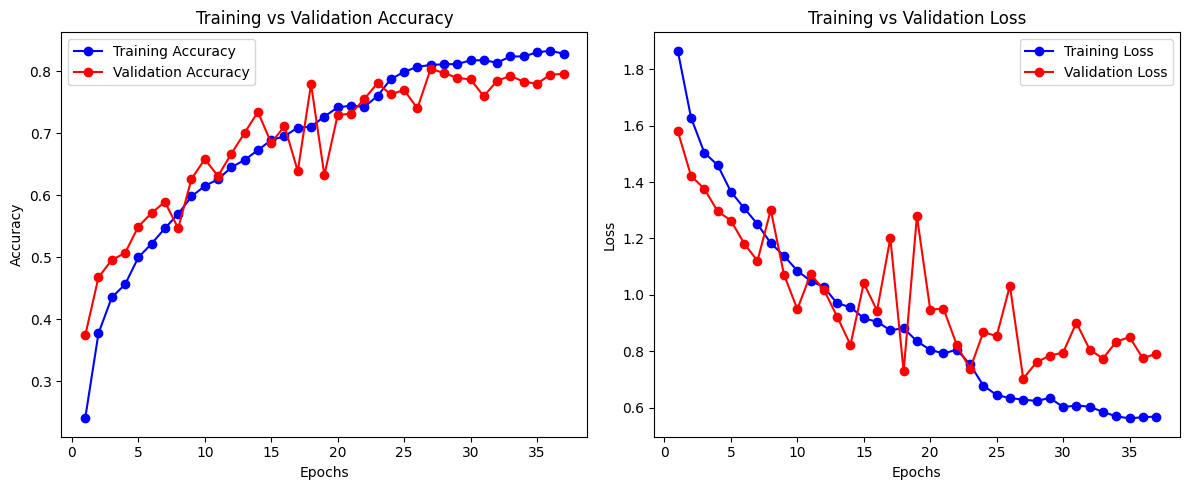

In [28]:
import matplotlib.pyplot as plt
# Visualize the training process
acc = history.history["sparse_categorical_accuracy"]
val_acc = history.history["val_sparse_categorical_accuracy"]
loss = history.history['loss']
val_loss = history.history['val_loss']
n_epochs = range(1, len(loss) + 1)

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(n_epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(n_epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(n_epochs, loss, 'bo-', label='Training Loss')
plt.plot(n_epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [29]:
# Train, val, and test loss and accuracy
train_loss, train_acc = model.evaluate(train_dataset)
val_loss, val_acc = model.evaluate(val_dataset)
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Self-attention model's train accuracy: {train_acc:.4f}")
print(f"Self-attention model's train loss: {train_loss:.4f}")
print(f"Self-attention model's val accuracy: {val_acc:.4f}")
print(f"Self-attention model's val loss: {val_loss:.4f}")
print(f"Self-attention's model test accuracy: {test_acc:.4f}")
print(f"Self-attention model's test loss: {test_loss:.4f}")

268/268 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.5889 - sparse_categorical_accuracy: 0.8205
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.6768 - sparse_categorical_accuracy: 0.8123
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.6592 - sparse_categorical_accuracy: 0.8098
Self-attention model's train accuracy: 0.8201
Self-attention model's train loss: 0.5858
Self-attention model's val accuracy: 0.8035
Self-attention model's val loss: 0.7035
Self-attention's model test accuracy: 0.8155
Self-attention model's test loss: 0.6535


84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


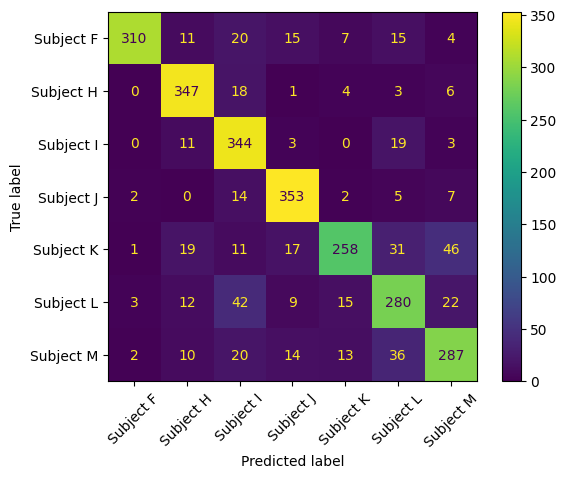

In [33]:
# Confusion matrix
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_LABELS)
disp.plot(cmap = "viridis")
plt.xticks(rotation=45)
plt.show()

In [36]:
# Classification report
report = classification_report(y_test, y_pred, target_names = CLASS_LABELS)
print(report)

              precision    recall  f1-score   support

   Subject F       0.97      0.81      0.89       382
   Subject H       0.85      0.92      0.88       379
   Subject I       0.73      0.91      0.81       380
   Subject J       0.86      0.92      0.89       383
   Subject K       0.86      0.67      0.76       383
   Subject L       0.72      0.73      0.73       383
   Subject M       0.77      0.75      0.76       382

    accuracy                           0.82      2672
   macro avg       0.82      0.82      0.81      2672
weighted avg       0.82      0.82      0.81      2672

